In [32]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.figure, matplotlib.axes
import sys
import numpy as np
import pickle as pkl
import yaml 
import tqdm
import collections.abc
import torch
from utils import PredictionResults, deframe_axes, export_legend
import os


deepracing_path = os.environ["DEEPRACING_PATH"]
print(deepracing_path)

deepracingmodelsdir = os.path.abspath(os.path.join(deepracing_path, "DCNN-Pytorch"))
deepracingdir = os.path.abspath(os.path.join(deepracing_path, "deepracing_py"))
if (not (deepracingmodelsdir in sys.path)) or (not (deepracingdir in sys.path)):
    sys.path = [deepracingmodelsdir, deepracingdir] + sys.path

homedir = os.environ["HOME"]

mtrdir=os.path.join(homedir, "deepracingws", "MTR")
print(mtrdir)
if (not (mtrdir in sys.path)):
    sys.path.insert(0, mtrdir)
print(sys.path)
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/l/ttw2xk/deepracingws/src/deepracing
/l/ttw2xk/deepracingws/MTR
['/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch', '/l/ttw2xk/deepracingws/src/deepracing/deepracing_py', '/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch/plotting', '/p/DeepRacing/deepracingws/src/deepracing/DCNN-Pytorch', '/p/DeepRacing/deepracingws/src/deepracing/deepracing_py', '/sw/ubuntu-22.04/python/3.10.13/lib/python310.zip', '/sw/ubuntu-22.04/python/3.10.13/lib/python3.10', '/sw/ubuntu-22.04/python/3.10.13/lib/python3.10/lib-dynload', '', '/l/ttw2xk/python3venvs/deepracing310/lib/python3.10/site-packages', '/l/ttw2xk/deepracingws/MTR']


In [2]:

from deepracing_models.data_loading import SubsetFlag
import deepracing_models.math_utils as mu
import deepracing_models.data_loading.file_datasets as FD
import deepracing_models.data_loading.utils.file_utils as file_utils
import torch.utils.data as torchdata
keys : set = {
    "hist",
    "hist_quats",
    "hist_vel",
    "fut",
    "fut_tangents",
    "fut_quats",
    "fut_vel",
    "left_bd",
    "right_bd",
    "future_left_bd",
    "future_right_bd",
    "future_centerline",
    "future_raceline",
    "thistory",
    "tfuture",
    "future_arclength",
    "future_left_bd_arclength",
    "future_right_bd_arclength",
    "future_centerline_arclength",
    "future_raceline_arclength",
    "future_left_bd_tangents",
    "future_right_bd_tangents",
    "future_centerline_tangents",
    "future_raceline_tangents"
}
dsets : list[FD.TrajectoryPredictionDataset] = \
    file_utils.load_datasets_from_files("/p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard",
                                     flag=SubsetFlag.TEST, keys=keys)
fulldset : torchdata.ConcatDataset = torchdata.ConcatDataset(dsets)


bezier_experiment = "widespread_beans_6059"
bezier_results_dir = os.path.join("/p/DeepRacing/mixnet_bezier_results", bezier_experiment)
bezier_results = PredictionResults.from_data_file(os.path.join(bezier_results_dir, "data.npz"), "BezierMixNet")
bezier_results.compute_fde()

# composite_experiment = "sunny_coyote_3579"
composite_experiment = "chosen_preservative_7505"
# composite_experiment = "relevant_joint_2105"
barte_results_dir = os.path.join("/p/DeepRacing/bamf_results", composite_experiment)
barte_results = PredictionResults.from_data_file(os.path.join(barte_results_dir, "data.npz"), "BARTé")
barte_results.compute_fde()
composite_curves = torch.as_tensor(barte_results["curves"], dtype=torch.float64, device=torch.device("cpu"))
kbezier = composite_curves.shape[-2] - 1
num_segments = composite_curves.shape[-3]
tfuture_np = np.stack([fulldset[i]["tfuture"] for i in range(len(fulldset))], axis=0)
tfuture = torch.as_tensor(tfuture_np, dtype=composite_curves.dtype, device=composite_curves.device)
tfuture = tfuture - tfuture[:,[0,]]
tswitch = torch.stack([torch.linspace(tfuture[i,0], tfuture[i,-1], steps=num_segments+1, dtype=tfuture.dtype, device=tfuture.device) for i in range(tfuture.shape[0])], dim=0)
tstart = tswitch[:,:-1]
tend = tswitch[:,1:]
dt = tend - tstart
composite_curve_derivs = kbezier*(composite_curves[:,:,1:] - composite_curves[:,:,:-1])/(dt[:,:,None,None])
vels_eval, _ = mu.compositeBezierEval(tstart, dt, composite_curve_derivs, tfuture)
barte_results["vel_predictions"] = vels_eval.cpu().numpy()


mixnet_experiment = "agricultural_flue_8932"
mixnet_results_dir = os.path.join("/p/DeepRacing/mixnet_results", mixnet_experiment)
mixnet_results = PredictionResults.from_data_file(os.path.join(mixnet_results_dir, "data.npz"), "MixNet")
mixnet_results["ground_truth"] = np.stack([fulldset[i]["fut"].copy() for i in range(len(fulldset))], axis=0)
mixnet_results.compute_fde()

mtr_experiment = "formal_pedestal_9890"
mtr_results_dir =  os.path.join("/p/DeepRacing/mtr_results", mtr_experiment)
mtr_data_dir = "/p/DeepRacing/unpacked_datasets/local_fitting/v1/mtr_format/1second"
mtr_scenarios_dir = os.path.join(mtr_data_dir, "processed_scenarios_test")
mtr_sortfile = os.path.join(mtr_results_dir, "test_plots", "idx_sort.npz")
if not os.path.isfile(mtr_sortfile):
    with open(os.path.join(mtr_data_dir, "processed_scenarios_test_infos.pkl"), "rb") as f:
        mtr_infos = pkl.load(f)
    mtr_keys = mtr_infos[0].keys()
    entries = []
    for (idx, info) in tqdm.tqdm(enumerate(mtr_infos), total=len(mtr_infos)):
        scenario_id = info["scenario_id"]
        with open(os.path.join(mtr_scenarios_dir, scenario_id+".metadata.yaml"), "r") as f:
            scenario_metadata = yaml.safe_load(f)
        deepracing_dir = os.path.dirname(scenario_metadata["deepracing_file"])
        dset_index = scenario_metadata["index"]
        car_index = int(os.path.basename(deepracing_dir).split("_")[-1])
        dated_trackname : str = os.path.basename(os.path.dirname(deepracing_dir))
        trackname = dated_trackname.split("_")[0]
        entries.append((idx, scenario_id, trackname, car_index, dset_index))
    entries_sorted = sorted(entries, key=lambda entry : (entry[2], entry[3], entry[4]))
    scenario_ids_sorted = np.asarray([e[1] for e in entries_sorted], dtype=object)
    idx_sort = np.asarray([e[0] for e in entries_sorted], dtype=np.int64)
    with open(mtr_sortfile, "wb") as f:
        np.savez(f, idx_sort=idx_sort, scenario_ids=scenario_ids_sorted)

with open(mtr_sortfile, "rb") as f:
    npfile = np.load(f, allow_pickle=True)
    sort_idx_mtr = npfile["idx_sort"].copy()
    scenario_ids_sorted = npfile["scenario_ids"].copy()

mtr_results = PredictionResults.from_data_file(os.path.join(mtr_results_dir, "test_plots", "data.npz"), "MTR", sort_idx=sort_idx_mtr)
mtr_results["predictions_all"] = mtr_results["predictions"].copy()
mtr_results["predictions"] = np.zeros_like(mtr_results["predictions_all"][:,0])
for idx in range(mtr_results["predictions_all"].shape[0]):
    mtr_results["predictions"][idx] = mtr_results["predictions_all"][idx,mtr_results["best_curve_idx"][idx]]
mtr_results.compute_fde()
# for k in ["history", "ground_truth"]

all_history = np.stack([fulldset[i]["hist"] for i in range(len(fulldset))], axis=0)
all_leftbound = np.stack([fulldset[i]["future_left_bd"] for i in range(len(fulldset))], axis=0)
all_rightbound = np.stack([fulldset[i]["future_right_bd"] for i in range(len(fulldset))], axis=0)
for result in [bezier_results, mtr_results, barte_results, mixnet_results]:
    result["left_bd"] = all_leftbound.copy()
    result["right_bd"] = all_rightbound.copy()
    print("%s has %d points" % (result.modelname, result["history"].shape[0]))
    print("%s has keys: %s" % (result.modelname, str(list(result.keys()))))



Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_0/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_1/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_2/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_3/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_4/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_5/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepr

In [3]:
%autoreload 2
from torch.utils.data import Subset
from utils import plot_error_histograms, plot_outliers

whis=None
pf=98.0
metric="ade"
results_base = "/p/DeepRacing/trajectory_prediction_results/sim_data"
nonoutliers, _ = barte_results.trim_percentiles(metric=metric, pf=pf)
outliers = ~nonoutliers
print(len(fulldset))
print(np.sum(nonoutliers))
print(np.sum(outliers))

composite_results_trimmed = barte_results.subsample(nonoutliers)
bezier_results_trimmed = bezier_results.subsample(nonoutliers)
mtr_results_trimmed = mtr_results.subsample(nonoutliers)
mixnet_results_trimmed = mixnet_results.subsample(nonoutliers)
fulldset_trimmed = Subset(fulldset, [i for i in range(nonoutliers.shape[0]) if bool(nonoutliers[i])])


# print(np.sum(mtr_nonoutliers*(~barte_nonoutliers)))
# print(np.sum(barte_nonoutliers*(~mtr_nonoutliers)))

126577
124045
2532


In [4]:


import shutil

rcparams_latex = {
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
}

plots_dir = os.path.join(results_base, "plots")
histograms_dir = os.path.join(results_base, "histograms")
plots_dir_trimmed = os.path.join(results_base, "plots_trimmed")
histograms_dir_trimmed = os.path.join(results_base, "histograms_trimmed")

In [5]:
from utils import create_table
from texttable import Texttable

results_textable = create_table([barte_results, mtr_results, mixnet_results, bezier_results])
results_textable.set_deco(Texttable.BORDER | Texttable.HLINES | Texttable.HEADER | Texttable.VLINES)
print(results_textable.draw())
results_trimmed_textable = create_table([composite_results_trimmed, mtr_results_trimmed, mixnet_results_trimmed, bezier_results_trimmed])
results_trimmed_textable.set_deco(Texttable.BORDER | Texttable.HLINES | Texttable.HEADER | Texttable.VLINES)
print(results_trimmed_textable.draw())

+--------------+-------+-------+---------+--------------+
|    Model     |  ADE  |  FDE  | Lateral | Longitudinal |
|              |       |       |  Error  |    Error     |
+==============+=======+=======+=========+==============+
|    BARTé     | 0.504 | 1.008 |  0.283  |    0.348     |
+--------------+-------+-------+---------+--------------+
|     MTR      | 0.524 | 1.065 |  0.175  |    0.450     |
+--------------+-------+-------+---------+--------------+
|    MixNet    | 1.892 | 3.476 |  0.463  |    1.706     |
+--------------+-------+-------+---------+--------------+
| BezierMixNet | 0.775 | 0.720 |  0.541  |    0.412     |
+--------------+-------+-------+---------+--------------+
+--------------+-------+-------+---------+--------------+
|    Model     |  ADE  |  FDE  | Lateral | Longitudinal |
|              |       |       |  Error  |    Error     |
+==============+=======+=======+=========+==============+
|    BARTé     | 0.484 | 0.965 |  0.278  |    0.330     |
+-------------

In [6]:
N=-1
maindir = "/p/DeepRacing/trajectory_prediction_results/sim_data/cross_error_analysis"
basedir = os.path.join(maindir, metric)
all_results_composite_ref = [barte_results, mtr_results, mixnet_results, bezier_results]
all_results_mtr_ref = [mtr_results, barte_results, mixnet_results, bezier_results]


In [7]:
%autoreload 2
from utils import cross_error_analysis
cross_error_analysis(all_results_composite_ref, fulldset, basedir, metric=metric, other_models=[mtr_results.modelname,], N=N)

In [8]:
%autoreload 2
from utils import cross_error_analysis
cross_error_analysis(all_results_composite_ref, fulldset, basedir, pf=pf, whis=whis, metric=metric, other_models=[mtr_results.modelname,], N=N)
cross_error_analysis(all_results_mtr_ref,       fulldset, basedir, pf=pf, whis=whis, metric=metric, other_models=[barte_results.modelname,], N=N)

In [9]:

total_samples = barte_results[metric].shape[0]

barte_nonoutliers, barte_maxval = barte_results.trim_percentiles(metric=metric, pf=pf)
mtr_nonoutliers, mtr_maxval = mtr_results.trim_percentiles(metric=metric, pf=pf)

# mtr_nonoutliers, mtr_maxval = mtr_results.trim_iqr(metric=metric, whis=whis)
# barte_nonoutliers, barte_maxval = composite_results.trim_iqr(metric=metric, whis=whis)


In [10]:
barte_inliers = barte_results[metric]<=barte_maxval 
mtr_inliers = mtr_results[metric]<=mtr_maxval
basedir = os.path.join(os.path.dirname(maindir), "both_models_good_merged", metric)
os.makedirs(basedir, exist_ok=True)
cross_error_analysis([mtr_results, barte_results], fulldset, basedir, idx_filter=barte_inliers*mtr_inliers, subdir=".", metric=metric, other_models=[barte_results.modelname,], N=N)

In [11]:
barte_inliers = barte_results[metric]<=barte_maxval 
mtr_inliers = mtr_results[metric]<=barte_maxval
basedir = os.path.join(os.path.dirname(maindir), "both_models_good_barte_maxval", metric)
os.makedirs(basedir, exist_ok=True)
cross_error_analysis([mtr_results, barte_results], fulldset, basedir, idx_filter=barte_inliers*mtr_inliers, subdir=".", metric=metric, other_models=[barte_results.modelname,], N=N)


In [12]:
barte_inliers = barte_results[metric]<=mtr_maxval
mtr_inliers = mtr_results[metric]<=mtr_maxval
both_good = barte_inliers*mtr_inliers
basedir = os.path.join(os.path.dirname(maindir), "both_models_good_mtr_maxval", metric)
os.makedirs(basedir, exist_ok=True)
cross_error_analysis([mtr_results, barte_results], fulldset, basedir, idx_filter=barte_inliers*mtr_inliers, subdir=".", metric=metric, other_models=[barte_results.modelname,], N=N)


In [13]:
%autoreload 2
from utils import cross_error_analysis


barte_outliers = ~barte_nonoutliers
mtr_outliers = ~mtr_nonoutliers
both_bad = barte_outliers*mtr_outliers
basedir = os.path.join(os.path.dirname(maindir), "both_models_bad_merged", metric)
os.makedirs(basedir, exist_ok=True)
cross_error_analysis([mtr_results, barte_results], fulldset, basedir, idx_filter=barte_outliers*mtr_outliers, subdir=".", metric=metric, other_models=[barte_results.modelname,], N=N)



In [14]:
%autoreload 2
from utils import cross_error_analysis


barte_outliers = barte_results[metric]>barte_maxval
mtr_outliers = mtr_results[metric]>barte_maxval
basedir = os.path.join(os.path.dirname(maindir), "both_models_bad_barte_maxval", metric)
os.makedirs(basedir, exist_ok=True)
cross_error_analysis([mtr_results, barte_results], fulldset, basedir, idx_filter=barte_outliers*mtr_outliers, subdir=".", metric=metric, other_models=[barte_results.modelname,], N=N)



In [15]:

barte_outliers = barte_results[metric]>mtr_maxval
mtr_outliers = mtr_results[metric]>mtr_maxval
basedir = os.path.join(os.path.dirname(maindir), "both_models_bad_mtr_maxval", metric)
os.makedirs(basedir, exist_ok=True)
cross_error_analysis([mtr_results, barte_results], fulldset, basedir, idx_filter=barte_outliers*mtr_outliers, subdir=".", metric=metric, other_models=[barte_results.modelname,], N=N)


35839
dict_keys(['future_left_bd', 'thistory', 'fut_tangents', 'future_centerline_arclength', 'future_right_bd_tangents', 'left_bd', 'future_raceline_tangents', 'future_arclength', 'future_right_bd', 'hist', 'hist_vel', 'future_raceline', 'future_centerline', 'future_right_bd_arclength', 'tfuture', 'future_left_bd_tangents', 'future_centerline_tangents', 'fut', 'hist_quats', 'right_bd', 'future_left_bd_arclength', 'fut_quats', 'future_raceline_arclength', 'fut_vel', 'trackname'])
[ 0 20 40 60]


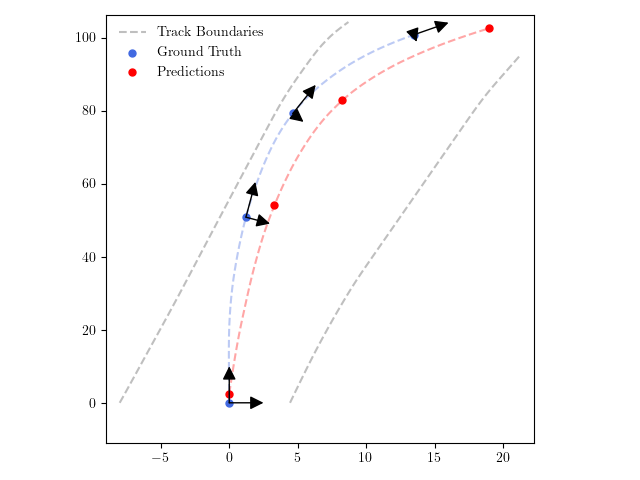

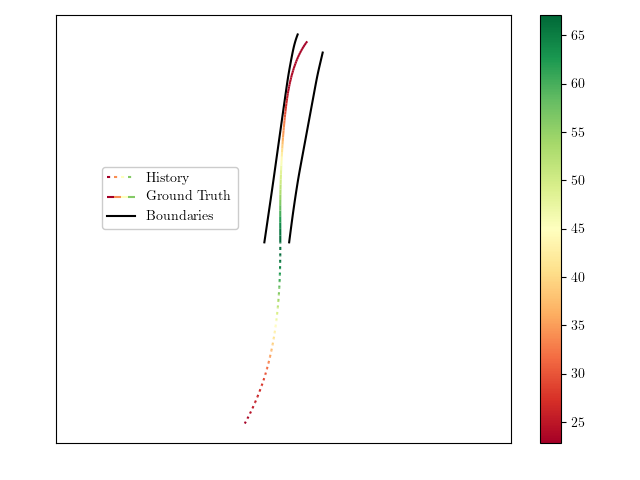

In [339]:


# idx_good = plot_outliers([composite_results, mtr_results, mixnet_results, bezier_results], plots_dir, fulldset, N=25, metric_key="ade", worst=False)




# sample = fulldset[idx_good[26]]
from scipy.spatial.transform import Rotation
from matplotlib.collections import LineCollection, Collection
from matplotlib.colors import BoundaryNorm, ListedColormap, Colormap
from matplotlib.legend_handler import HandlerLineCollection
from matplotlib.patches import ArrowStyle
import matplotlib.cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.axes, matplotlib.figure
from operator import sub
def get_aspect(ax):
    # Total figure size
    figW, figH = ax.get_figure().get_size_inches()
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return disp_ratio / data_ratio
class HandlerColorLineCollection(HandlerLineCollection):
    def create_artists(self, legend, artist ,xdescent, ydescent,
                        width, height, fontsize,trans):
        x = np.linspace(0,width,self.get_numpoints(legend)+1)
        y = np.zeros(self.get_numpoints(legend)+1)+height/2.-ydescent
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=artist.cmap,
                     transform=trans, linestyle=artist.get_linestyle())
        lc.set_array(x)
        lc.set_linewidth(artist.get_linewidth())
        return [lc]
def add_colored_line(points : np.ndarray, cvals : np.ndarray, ax : matplotlib.axes.Axes, cmap : str | Colormap, 
    linestyle="solid", alpha=1.0) -> tuple[LineCollection, Collection]:
    points_exp = points.reshape(-1, 1, points.shape[-1])
    segments = np.concatenate([points_exp[:-1], points_exp[1:]], axis=1)
    norm = plt.Normalize(cvals.min(), cvals.max())
    lc = LineCollection(segments, cmap=cmap, norm=norm,linestyle=linestyle, alpha=alpha)
    
    lc.set_array(cvals)
    line = ax.add_collection(lc)
    return lc, line
# mtr_outliers = ~mtr_nonoutliers
# mtr_outliers_idx = np.where(mtr_outliers)[0]
mtr_argsort = np.flipud(np.argsort(mtr_results["ade"]))
# idx_rand = np.random.choice(mtr_outliers_idx)
idx_rand = mtr_argsort[7]
sample = fulldset[idx_rand]
print(idx_rand)
print(sample.keys())

Rmat = Rotation.from_rotvec([0.0, 0.0, 0.5*np.pi]).as_matrix()[0:2,0:2]
history_start = 30
history = (Rmat @ sample["hist"][history_start:,[0,1]].T).T
history_vels = (Rmat @ sample["hist_vel"][history_start:,[0,1]].T).T
history_speeds = np.linalg.norm(history_vels, ord=2.0, axis=1)

ground_truth = (Rmat @ sample["fut"][:,[0,1]].T).T
ground_truth_tangents = (Rmat @ sample["fut_tangents"][:,[0,1]].T).T
ground_truth_tangents/=np.linalg.norm(ground_truth_tangents, ord=2, axis=1, keepdims=True)
ground_truth_vels = (Rmat @ sample["fut_vel"][:,[0,1]].T).T
ground_truth_speeds = np.linalg.norm(ground_truth_vels, ord=2.0, axis=1)

all_points = np.concatenate([history, ground_truth], axis=0)
all_speeds = np.concatenate([history_speeds, ground_truth_speeds], axis=0)




thistory = sample["thistory"]
tfuture = sample["tfuture"]
future_left_bd = (Rmat @ sample["future_left_bd"][:,[0,1]].T).T
future_right_bd = (Rmat @ sample["future_right_bd"][:,[0,1]].T).T
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
asdf : tuple[matplotlib.figure.Figure, matplotlib.axes.Axes] = plt.subplots(1,1)
fig : matplotlib.figure.Figure = asdf[0]
ax : matplotlib.axes.Axes = asdf[1]
ax.plot(future_left_bd[:,0], future_left_bd[:,1], linestyle="solid", color="black")
boundaries = ax.plot(future_right_bd[:,0], future_right_bd[:,1], linestyle="solid", color="black")
norm = plt.Normalize(all_speeds.min(), all_speeds.max(), clip=True)
cmap = "RdYlGn"
scalar_mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
lc_hist, line_hist = add_colored_line(history, history_speeds[:-1], ax, cmap, linestyle="dotted")
lc_ground_truth, line_ground_truth  = add_colored_line(ground_truth, ground_truth_speeds[:-1], ax, cmap)
line_ground_truth.set_label("asdf")
lc_ground_truth.set_label("asdf")
# lc_fake, line_fake  = add_colored_line(all_points, all_speeds[:-1], ax, cmap, alpha=0.25)

# ax.plot(history[:,0], history[:,1], linestyle="--", color=history_speeds, cmap="viridis", norm=norm, alpha=0.5, label="History")
# ax.plot(ground_truth[:,0], ground_truth[:,1], linestyle="dotted", color="black", label="Ground Truth")
ax.axis("equal")
ax.legend([
               lc_hist, 
               lc_ground_truth,
               boundaries[0],
           ],
           [
               "History", 
               "Ground Truth", 
               "Boundaries",
           ], loc=(0.1, 0.5),
          handler_map={
              lc_hist: HandlerColorLineCollection(numpoints=4),
              lc_ground_truth: HandlerColorLineCollection(numpoints=4),

            },
            framealpha=1)
fig.tight_layout()
os.makedirs(plots_dir, exist_ok=True)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(plots_dir, "label_nobar.svg"), pad_inches=0.02)
fig.savefig(os.path.join(plots_dir, "label_nobar.pdf"), pad_inches=0.02)
fig.colorbar(scalar_mappable, ax=ax)
fig.savefig(os.path.join(plots_dir, "label.svg"), pad_inches=0.02)
fig.savefig(os.path.join(plots_dir, "label.pdf"), pad_inches=0.02)

Rtilt = Rotation.from_rotvec([0.0, 0.0, 2.25*np.pi/180.0]).inv().as_matrix()[0:2,0:2]
fig2, _ax2_  = plt.subplots()
ax2 : matplotlib.axes.Axes = _ax2_
# ax2.plot(thistory[history_start:], history_speeds)
# ax2.plot(tfuture, ground_truth_speeds)
# boundaryskip = 2
# lbscatter = ax2.scatter(future_left_bd[::boundaryskip,0], future_left_bd[::boundaryskip,1], color="black", s=12.5, alpha=0.5)
# rbscatter = ax2.scatter(future_right_bd[::boundaryskip,0],future_right_bd[::boundaryskip,1], color=lbscatter.get_facecolor(), s=lbscatter.get_sizes(), alpha=lbscatter.get_alpha())
boundaryskip = None
lbplot = ax2.plot(future_left_bd[::boundaryskip,0], future_left_bd[::boundaryskip,1], color="grey", linestyle="--", alpha=0.5, label="Track Boundaries")
rbplot = ax2.plot(future_right_bd[::boundaryskip,0],future_right_bd[::boundaryskip,1], color=lbplot[0].get_color(), linestyle=lbplot[0].get_linestyle(), alpha=lbplot[0].get_alpha())

gtplotidx = np.linspace(0.0, float(ground_truth.shape[0] - 1), num=4).round().astype(np.int64)
gtscatter = ax2.scatter(ground_truth[gtplotidx,0], ground_truth[gtplotidx,1], color="royalblue", s=5.0**2, label="Ground Truth")
gtplot = ax2.plot(ground_truth[:,0], ground_truth[:,1], color=gtscatter.get_facecolor(), linestyle="--", alpha=0.35)

# labelidx = np.linspace(4, float(barte_results["predictions"][idx_rand].shape[0] - 1), num=4).round().astype(np.int64)
barte_preds = (barte_results["predictions"][idx_rand] @ (Rmat@Rtilt).T)
barte_preds += 2.5*ground_truth_tangents
mtr_preds = (mtr_results["predictions"][idx_rand] @ (Rmat@Rtilt).T)
# mtr_preds += 2.5*ground_truth_tangents
# mtr_preds[-1]+=2.5*ground_truth_tangents[-1]
# mtr_preds[
# labelidx = np.asarray( (gtplotidx[::2]).tolist() + [barte_preds.shape[0]-1,], dtype=np.int64)
labelidx = gtplotidx
print(labelidx)
# bartescatter = ax2.scatter(barte_preds[:,0], barte_preds[:,1], color="red", label="Predictions", s=gtscatter.get_sizes())
bartescatter = ax2.scatter(barte_preds[labelidx,0], barte_preds[labelidx,1], color="red", label="Predictions", s=gtscatter.get_sizes())
barteplot = ax2.plot(barte_preds[:,0], barte_preds[:,1], color=bartescatter.get_facecolor(), linestyle="--", alpha=gtplot[0].get_alpha())
# mtrscatter = ax2.scatter(mtr_preds[:,0], mtr_preds[:,1], color="red", label="Predictions", s=gtscatter.get_sizes())
# mtrscatter = ax2.scatter(mtr_preds[labelidx,0], mtr_preds[labelidx,1], color="red", label="Predictions", s=gtscatter.get_sizes())

ground_truth_normals = ground_truth_tangents[:,[1,0]].copy()
# ground_truth_normals[:,1]*=-1.0

# long_label_distance = np.sum((mtr_preds[labelidx[-1]]-ground_truth[labelidx[-1]])*ground_truth_normals[labelidx[-1]]) 



limdelta = 1.0
xmin = np.min(future_left_bd[:,0]) - limdelta
xmax = np.max(future_right_bd[:,0]) + limdelta
ax2.set_xlim(xmin,xmax)

limdelta = 11.0
ymin = np.min(future_right_bd[:,1]) - limdelta
ymax = np.max(future_right_bd[:,1]) + limdelta
ax2.set_ylim(ymin,ymax)
aspect_ratio = (xmax - xmin)/(ymax - ymin)
affinemat = np.eye(3)
affinemat[0,0] = aspect_ratio
affinemat[1,1] = 1/aspect_ratio
ax2.set_aspect(aspect_ratio)
import matplotlib.transforms
affinetransform = matplotlib.transforms.Affine2D(affinemat)


ground_truth_tangents_uv = ground_truth_tangents.copy()# @ (affinemat[:-1,:-1])
ground_truth_tangents_uv[:,0]/=aspect_ratio
ground_truth_tangents_uv/=np.linalg.norm(ground_truth_tangents_uv, ord=2.0, axis=1, keepdims=True)

# ground_truth_normals_uv = ground_truth_tangents_uv[:,[1,0]].copy()
# ground_truth_normals_uv[:,0]*=-1.0

ground_truth_normals_uv = ground_truth_normals.copy()# @ (affinemat[:-1,:-1].T)
ground_truth_normals_uv[:,1]/=aspect_ratio
ground_truth_normals_uv/=np.linalg.norm(ground_truth_normals_uv, ord=2.0, axis=1, keepdims=True)
# ground_truth_normals_uv = ground_truth_tangents_uv[:,[1,0]].copy()
# ground_truth_normals_uv[:,0]/=-aspect_ratio
# ground_truth_normals_uv/=np.linalg.norm(ground_truth_normals_uv, ord=2.0, axis=1, keepdims=True)

arrow_props = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
        shrinkA=0,shrinkB=0,fc="black")
# tangentarrows = ax2.quiver(ground_truth[labelidx,0], ground_truth[labelidx,1], ground_truth_tangents_uv[labelidx,0], ground_truth_tangents_uv[labelidx,1],
#                            angles="uv", units="xy",  scale=1.0E-1, width=0.45)#, transform=affinetransform)
# normalarrows = ax2.quiver(ground_truth[labelidx,0], ground_truth[labelidx,1], ground_truth_normals_uv[labelidx,0], ground_truth_normals_uv[labelidx,1],
#                         angles='uv', units='xy', scale=1.0E-1, width=0.45)

for i in labelidx.tolist():
    basepoint = ground_truth[i]
    xycoords="data"
    textcoords="data"

    delta_tangent = ground_truth_tangents_uv[i]
    r_tangent = 10.0*np.sqrt((delta_tangent[0]*aspect_ratio)**2 + (delta_tangent[1])**2)
    deltavec_tangent = r_tangent*ground_truth_tangents[i]
    tippoint_tangent = basepoint + deltavec_tangent
    ax2.annotate("", xy=tippoint_tangent, xycoords=xycoords, xytext=basepoint, textcoords=textcoords, arrowprops=arrow_props)

    deltavec_normal = ground_truth_normals[i].copy()
    deltavec_normal[1]*=-1.0/aspect_ratio**2
    deltavec_normal/=np.linalg.norm(deltavec_normal, ord=2)

    theta = np.arctan2(delta_tangent[1], delta_tangent[0])
    r_normal = 10.0*np.sqrt((delta_tangent[0])**2 + (delta_tangent[1]*aspect_ratio)**2)
    #*np.sqrt((delta_tangent[0])**2 + (delta_tangent[1]*aspect_ratio)**2)
    tippoint_normal = basepoint + r_normal*deltavec_normal
    ax2.annotate("", xy=tippoint_normal, xycoords=xycoords, xytext=basepoint, textcoords=textcoords, arrowprops=arrow_props)
    # tippoint_normal = basepoint + r*ground_truth_normals_uv[i]
    # ax2.annotate("", xy=tippoint_normal, xycoords=xycoords, xytext=basepoint, textcoords=textcoords, arrowprops=arrow_props)


# proj_idx=labelidx[-1]
# diff = barte_preds[proj_idx] - ground_truth[proj_idx]
# euclidean_distance = np.linalg.norm(diff, ord=2.0)
# diff[0]*=aspect_ratio
# proj_distance = np.abs(np.sum(diff*ground_truth_tangents[proj_idx]))
# long_proj_point = ground_truth[proj_idx] + proj_distance*ground_truth_normals_uv[proj_idx]
# ax2.scatter(long_proj_point[0], long_proj_point[1], s=bartescatter.get_sizes()[0])
# numdotted=2
# ax2.plot(np.linspace(long_proj_point[0], barte_preds[labelidx[-1],0], num=numdotted), np.linspace(long_proj_point[1], barte_preds[labelidx[-1],1], num=numdotted), linestyle="--", color="black", alpha=0.75)

# deframe_axes(ax2)
legend = ax2.legend(frameon=False)
fig2.tight_layout()
fig2.savefig(os.path.join(plots_dir, "lat_long_errors.svg"), pad_inches=0.02, transparent=True)
plt.show()
# plt.close(fig=fig)

(80, 2)


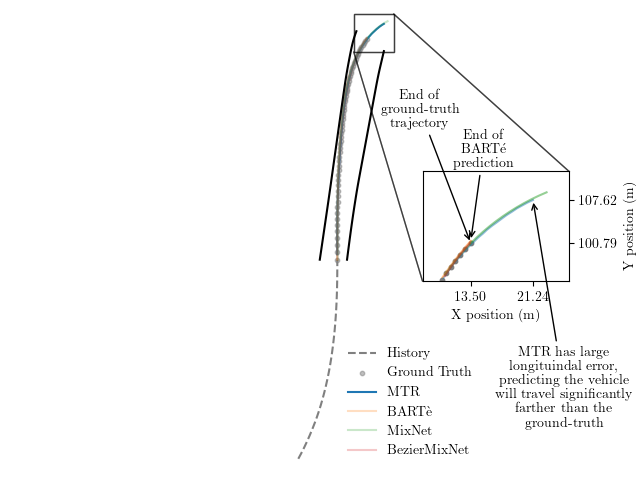

In [17]:
import os
import matplotlib.artist
import matplotlib.collections
import matplotlib.lines
import matplotlib.axes
plt.rcParams["text.usetex"]=True
results_list = all_results_mtr_ref
ref_results = results_list[0]
ref_alpha=1.0
nonref_alpha=0.25

artist_dict : dict[str,matplotlib.lines.Line2D | matplotlib.collections.PathCollection] = dict()
fig, _axmain_ = plt.subplots()
axmain : matplotlib.axes.Axes = _axmain_
history_label = "History"
artist_dict[history_label] = axmain.plot(history[:,0], history[:,1], label=history_label, linestyle="--", c="grey")[0]
ground_truth_label = "Ground Truth"
artist_dict[ground_truth_label] = axmain.scatter(ground_truth[:,0], ground_truth[:,1], label=ground_truth_label, c="grey", alpha=0.5, s=10.0)
print(ref_results["predictions"][idx_rand].shape)
mtr_predictions = (Rmat @ ref_results["predictions"][idx_rand][:,[0,1]].T).T
p0 = ground_truth[-1] - 6.0
pf = mtr_predictions[-1] + 4.5
delta = pf - p0
artist_dict[ref_results.modelname] = axmain.plot(mtr_predictions[:,0], mtr_predictions[:,1], label=ref_results.modelname, alpha=ref_alpha)[0]
predictions_dict : dict[str,np.ndarray] = dict()
predictions_dict[mtr_results.modelname] = mtr_predictions
predictions_dict["Ground Truth"] = ground_truth
predictions_inset_dict : dict[str,np.ndarray] = dict()
p0deltas = mtr_predictions - p0[None]
pfdeltas = -mtr_predictions + pf[None]
predictions_inset_dict[mtr_results.modelname] = mtr_predictions[np.prod(p0deltas>0.0, axis=1, dtype=bool)*np.prod(pfdeltas>0.0, axis=1, dtype=bool)].copy()
p0deltas = ground_truth - p0[None]
pfdeltas = -ground_truth + pf[None]
ground_truth_inset = ground_truth[np.prod(p0deltas>0.0, axis=1, dtype=bool)*np.prod(pfdeltas>0.0, axis=1, dtype=bool)].copy()
for (idx, results) in enumerate(results_list):
    if results==ref_results:
        continue
    predictions = (Rmat @ results["predictions"][idx_rand][:,[0,1]].T).T
    if results.modelname==barte_results.modelname:
        label="BART\\`e"
    else:
        label=results.modelname
    artist_dict[results.modelname] = axmain.plot(predictions[:,0], predictions[:,1], label=label, alpha=nonref_alpha)[0]
    predictions_dict[results.modelname] = predictions.copy()
    p0deltas = predictions - p0[None]
    pfdeltas = -predictions + pf[None]
    predictions_inset_dict[results.modelname] = predictions[np.prod(p0deltas>0.0, axis=1, dtype=bool)*np.prod(pfdeltas>0.0, axis=1, dtype=bool)].copy()
barte_predictions = predictions_dict[barte_results.modelname]
mixnet_predictions = predictions_dict[mixnet_results.modelname]

left_bound_input = sample["left_bd"]
artist_dict["left_bound"] = axmain.plot(future_left_bd[:,0], future_left_bd[:,1], color="black")[0]
right_bound_input = sample["right_bd"]
artist_dict["right_bound"] = axmain.plot(future_right_bd[:,0], future_right_bd[:,1], color=artist_dict["left_bound"].get_color())[0]
axmain.axis("equal")
fig.canvas.draw()
margins = axmain.margins()
xlim = np.asarray(axmain.get_xlim())
ylim = np.asarray(axmain.get_ylim())
lim_deltas = np.asarray([xlim[1] - xlim[0], ylim[1] - ylim[0]])
inset_origin = np.asarray([50, -10])
inset_origin_norm = (inset_origin - np.asarray([xlim[0], ylim[0]]))/lim_deltas
axinset : matplotlib.axes.Axes = axmain.inset_axes(
    [
        inset_origin_norm[0], 
        inset_origin_norm[1], 
        0.23, 
        0.23],
    xlim=(p0[0], pf[0]), ylim=(p0[1], pf[1]), xticklabels=[], yticklabels=[])
for (k, v) in predictions_inset_dict.items():
    mplobject = artist_dict[k]
    if type(mplobject) is matplotlib.collections.PathCollection:
        color = mplobject.get_facecolor()
    elif type(mplobject) is matplotlib.lines.Line2D:
        color = mplobject.get_color()
    else:
        raise ValueError("?")
    axinset.plot(v[:,0], v[:,1], label=k, color=color, alpha=0.5)
axinset.scatter(ground_truth_inset[:,0], ground_truth_inset[:,1], label="Ground Truth", c="grey", alpha=1.0, s=10.0)


axmain.indicate_inset_zoom(axinset, edgecolor="black")
axmain.get_xaxis().set_ticks([])
axmain.get_yaxis().set_ticks([])
for pos in ['right', 'top', 'bottom', 'left']: 
    axmain.spines[pos].set_visible(False) 
# xticks = np.linspace(p0[0]+0.1*delta[0], pf[0]-0.1*delta[0], num=3)
# yticks = np.linspace(p0[1]+0.1*delta[1], pf[1]-0.1*delta[1], num=3)
historymin = np.min(history[:,0])
historymax = np.max(history[:,0])
axmain.set_xlim(historymin, historymax + 2.0)
xticks = np.asarray([ground_truth[-1,0], mtr_predictions[-1,0]])
yticks = np.asarray([ground_truth[-1,1], mtr_predictions[-1,1]])
# xticks = yticks = []
axinset.set_xticks(xticks, ["%3.2f" % float(v) for v in xticks])
axinset.set_yticks(yticks, ["%3.2f" % float(v) for v in yticks])
axinset.yaxis.tick_right()
axinset.yaxis.set_label_position("right")
axinset.set_xlabel("X position (m)")
axinset.set_ylabel("Y position (m)")
# axinset.legend()
# fig.canvas.draw()
axmain.legend(frameon=False, loc="upper left", bbox_to_anchor=(0.525, 0.3))
fig.tight_layout(pad=0.1)
fig.savefig(os.path.join(plots_dir, "example_predictions_nolabels.pdf"), pad_inches=0.02, bbox_inches="tight")
fig.savefig(os.path.join(plots_dir, "example_predictions_nolabels.svg"), pad_inches=0.02, bbox_inches="tight")
fontsize=10
label_lines=["End of",
            "ground-truth",
            "trajectory"]
label=""
for line in label_lines:
    label+=line
    label+="\n"
label = label.strip()
angle = 105.25*np.pi/180.0
vec = np.asarray([np.cos(angle), np.sin(angle)])
gtend_annotation = axinset.annotate(label, 
                        ground_truth_inset[-1], xycoords="data",
                       xytext=115.0*vec, textcoords="axes points", fontsize=fontsize,
                       arrowprops=dict(arrowstyle=ArrowStyle.CurveB()),
                       annotation_clip=False, multialignment="center")
label_lines=["MTR has large",
            "longituindal error,",
            "predicting the vehicle",
            "will travel significantly",
            "farther than the",
            "ground-truth"]
label=""
for line in label_lines:
    label+=line
    label+="\n"
label = label.strip()
gtend_annotation = axinset.annotate(label, 
                        mtr_predictions[-1], xycoords="data",
                       xytext=105.0*np.asarray([0.5, -1.0]), textcoords="axes points", fontsize=fontsize,
                       arrowprops=dict(arrowstyle=ArrowStyle.CurveB()),
                       annotation_clip=False, multialignment="center")
axmain.indicate_inset_zoom(axinset, edgecolor="black")

label_lines=["End of",
            "BARTé",
            "prediction"]
label=""
for line in label_lines:
    label+=line
    label+="\n"
label = label.strip()
angle=75*np.pi/180.0
vec = np.asarray([np.cos(angle), np.sin(angle)])
barte_annotation = axinset.annotate(label, 
                        barte_predictions[-1], xycoords="data",
                       xytext=85.0*vec, textcoords="axes points", fontsize=fontsize,
                       arrowprops=dict(arrowstyle=ArrowStyle.CurveB()),
                       annotation_clip=False, multialignment="center")
fig.tight_layout(pad=0.1)
fig.savefig(os.path.join(plots_dir, "example_predictions.pgf"), pad_inches=0.02, bbox_inches="tight")
fig.savefig(os.path.join(plots_dir, "example_predictions.pdf"), pad_inches=0.02, bbox_inches="tight")
fig.savefig(os.path.join(plots_dir, "example_predictions.svg"), pad_inches=0.02, bbox_inches="tight")
plt.show()

In [18]:
from tqdm import tqdm
search=range(barte_results["curves"].shape[0])
residuals = np.zeros(len(search), dtype=np.float64)
singular_values = np.zeros([len(search), 4], dtype=residuals.dtype)
solutions = singular_values.copy()
for idx in tqdm(search, total=len(search)):
    labeldict = fulldset[idx]
    lb : np.ndarray = labeldict["future_left_bd"]
    rb : np.ndarray = labeldict["future_right_bd"]
    cl : np.ndarray = labeldict["future_centerline"]
    rl : np.ndarray = labeldict["future_raceline"]
    gt : np.ndarray = labeldict["fut"]
    allflat = np.stack([
        lb[:,[0,1]],
        rb[:,[0,1]],
        cl[:,[0,1]],
        rl[:,[0,1]],
        # np.ones_like(rl[:,[0,1]]),
    ], axis=2)
    # print(allflat.shape)
    # allflat = allflat.reshape(-1,allflat.shape[-1])
    # gt = torch.as_tensor(gt_[:,[0,1]], dtype=residuals.dtype)
    # print(allflat.shape)
    # print(gt.shape).reshape(-1)
    lhs = allflat.reshape(-1, allflat.shape[-1])#[None]
    rhs = gt[:,[0,1]].reshape(-1)#.unsqueeze(-1)
    # print(lhs.shape)
    # print(rhs.shape)
    # solution_, residuals_, rank_, singular_values_ = torch.linalg.lstsq(lhs, rhs, driver="gelss")
    # print(lhs.shape)
    # print(rhs.shape)
    solution_, residuals_, rank_, singular_values_ = np.linalg.lstsq(lhs, rhs)
    # print(residuals_.shape)
    residuals[idx] = float(residuals_[0])
    singular_values[idx,:] = singular_values_[:]
    solutions[idx,:] = solution_[:]
    # print(solution.shape)
    # print(residuals.shape)
    # print(rank.shape)
    # print(singular_values.shape)
    # print(solution)
    # if (singular_values[-1].item() < 2.5E-4):# or (residuals.item()>500.0):
    #     print(solution)
    #     print(residuals)
    #     print(rank)
    #     print(singular_values)
    #     print(idx)
    #     break

  0%|          | 0/126577 [00:00<?, ?it/s]/tmp/ipykernel_2606971/4189022609.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution_, residuals_, rank_, singular_values_ = np.linalg.lstsq(lhs, rhs)
100%|██████████| 126577/126577 [00:17<00:00, 7083.78it/s]


58142 0.00028818635203108046
110430 7682431.807459592
69202 756.5137768515287
dict_keys(['future_left_bd', 'thistory', 'fut_tangents', 'future_centerline_arclength', 'future_right_bd_tangents', 'left_bd', 'future_raceline_tangents', 'future_arclength', 'future_right_bd', 'hist', 'hist_vel', 'future_raceline', 'future_centerline', 'future_right_bd_arclength', 'tfuture', 'future_left_bd_tangents', 'future_centerline_tangents', 'fut', 'hist_quats', 'right_bd', 'future_left_bd_arclength', 'fut_quats', 'future_raceline_arclength', 'fut_vel', 'trackname'])
Building linear system
Solving linear system


/tmp/ipykernel_2606971/2213959270.py:25: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:63.)
  Rmat[:,1] = torch.cross(torch.as_tensor([0.0, 0.0, 1.0], dtype=gt_tangents.dtype), Rmat[:,0])


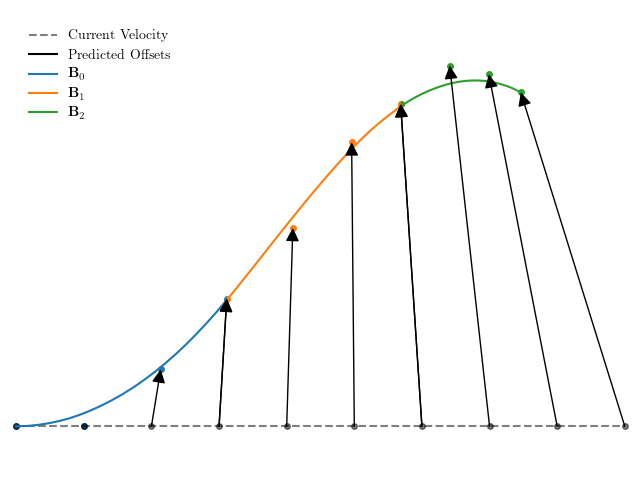

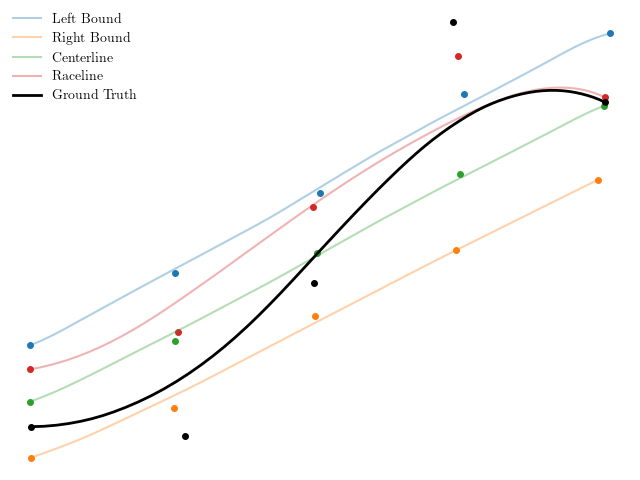

In [19]:
%autoreload 2
import deepracing_models.math_utils
from matplotlib.markers import MarkerStyle
# idx_rand2 = torch.randint(0, barte_results["curves"].shape[0], [1,]).item()
# idx_rand2 = 46983
# print(idx_rand2)
    # solution, residuals, rank, singular_values
# search=[45784,]
condition_numbers = singular_values[:,0]/singular_values[:,-1]

idx_ssv = np.argmin(singular_values[:,-1])
idx_mcn = np.argmax(condition_numbers)
idx_lsq = np.argmax(residuals)
print(idx_ssv, singular_values[idx_ssv,-1])
print(idx_mcn, condition_numbers[idx_mcn])
print(idx_lsq, residuals[idx_lsq])


labeldict = fulldset[idx_lsq]
print(labeldict.keys())
gt_tangents : torch.Tensor = torch.as_tensor(labeldict["fut_tangents"], dtype=torch.float64)
Rmat = torch.eye(3, dtype=gt_tangents.dtype)
Rmat[:,0] = gt_tangents[0]
Rmat[:,0]/= torch.norm(Rmat[:,0], p=2.0)
Rmat[:,1] = torch.cross(torch.as_tensor([0.0, 0.0, 1.0], dtype=gt_tangents.dtype), Rmat[:,0])
Rmat[:,1]/= torch.norm(Rmat[:,1], p=2.0)
Rmat[:,2] = torch.cross(Rmat[:,0], Rmat[:,1])
Rmat[:,2]/= torch.norm(Rmat[:,2], p=2.0)

gt_tangents = gt_tangents @ Rmat

lb : torch.Tensor = torch.as_tensor(labeldict["future_left_bd"], dtype=gt_tangents.dtype) @ Rmat
lb_tangents : torch.Tensor = torch.as_tensor(labeldict["future_left_bd_tangents"], dtype=gt_tangents.dtype) @ Rmat
lb_r : torch.Tensor = torch.as_tensor(labeldict["future_left_bd_arclength"], dtype=lb.dtype)

rb : torch.Tensor = torch.as_tensor(labeldict["future_right_bd"], dtype=lb.dtype) @ Rmat
rb_tangents : torch.Tensor = torch.as_tensor(labeldict["future_right_bd_tangents"], dtype=torch.float64) @ Rmat
rb_r : torch.Tensor = torch.as_tensor(labeldict["future_right_bd_arclength"], dtype=lb.dtype)

cl : torch.Tensor = torch.as_tensor(labeldict["future_centerline"], dtype=lb.dtype) @ Rmat
cl_tangents : torch.Tensor = torch.as_tensor(labeldict["future_centerline_tangents"], dtype=torch.float64) @ Rmat
cl_r : torch.Tensor = torch.as_tensor(labeldict["future_centerline_arclength"], dtype=lb.dtype)

rl : torch.Tensor = torch.as_tensor(labeldict["future_raceline"], dtype=lb.dtype) @ Rmat
rl_tangents : torch.Tensor = torch.as_tensor(labeldict["future_raceline_tangents"], dtype=torch.float64) @ Rmat
rl_r : torch.Tensor = torch.as_tensor(labeldict["future_raceline_arclength"], dtype=lb.dtype)

gt : torch.Tensor = torch.as_tensor(labeldict["fut"], dtype=lb.dtype) @ Rmat
gtvel : torch.Tensor = torch.as_tensor(labeldict["fut_vel"], dtype=lb.dtype) @ Rmat
gt_r : torch.Tensor = torch.as_tensor(labeldict["future_arclength"], dtype=lb.dtype)

tfuture : torch.Tensor = torch.as_tensor(labeldict["tfuture"], dtype=lb.dtype) - float(labeldict["tfuture"][0])
DT = tfuture[-1]

Nsegments = 3
kbeziercomposite = 3
gt_composite, t_switchingpoints = deepracing_models.math_utils.compositeBezierFit(tfuture[None], gt[None], Nsegments, kbezier=kbeziercomposite, dYdT_0=gtvel[[0,]], dYdT_f=gtvel[[-1,]])
gt_composite = gt_composite[0]
t_switchingpoints = t_switchingpoints[0]

all_r = torch.stack([lb_r, rb_r, cl_r, rl_r, gt_r], dim=0)
all_deltar = all_r[:,1] - all_r[:,0]
all_rs = (all_r - all_r[:,[0,]])/all_deltar[:,None]
all_pts = torch.stack([lb, rb, cl, rl, gt], dim=0)
all_tangents = torch.stack([lb_tangents, rb_tangents, cl_tangents, rl_tangents, gt_tangents], dim=0)
Mfit, all_fits = deepracing_models.math_utils.bezierLsqfit(all_pts, 4, t=all_r, P0=all_pts[:,0], Pf=all_pts[:,-1])#, V0=all_tangents[:,0])
lb_fit = all_fits[0].clone()
rb_fit = all_fits[1].clone()
cl_fit = all_fits[2].clone()
rl_fit = all_fits[3].clone()
gt_fit = all_fits[4].clone()

matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'text.usetex': True,
    'pgf.rcfonts': False,
    'svg.fonttype' : 'none'
})
fig, ax = plt.subplots()
lbplots=ax.plot(lb[:,0], lb[:,1], label="Left Bound", alpha=0.35)
lbscatter = ax.scatter(lb_fit[:,0], lb_fit[:,1], c=lbplots[0].get_color(), s=4.0**2)

rbplots=ax.plot(rb[:,0], rb[:,1], label="Right Bound", alpha=lbplots[0].get_alpha())
rbscatter = ax.scatter(rb_fit[:,0], rb_fit[:,1], c=rbplots[0].get_color(), s=lbscatter.get_sizes())

clplots=ax.plot(cl[:,0], cl[:,1], label="Centerline", alpha=lbplots[0].get_alpha())
clscatter = ax.scatter(cl_fit[:,0], cl_fit[:,1], c=clplots[0].get_color(), s=lbscatter.get_sizes())

rlplots=ax.plot(rl[:,0], rl[:,1], label="Raceline", alpha=lbplots[0].get_alpha())
rlscatter = ax.scatter(rl_fit[:,0], rl_fit[:,1], c=rlplots[0].get_color(), s=lbscatter.get_sizes())

gtplots=ax.plot(gt[:,0], gt[:,1], label="Ground Truth", alpha=1.0, color="black", lw=2.0)
gtscatter = ax.scatter(gt_fit[:,0], gt_fit[:,1], c=gtplots[0].get_color(), s=lbscatter.get_sizes())

ax.legend(frameon=False)
deframe_axes(ax)
fig.tight_layout(pad=0.05)

fig_composite, _ax_composite_ = plt.subplots()
ax_composite : matplotlib.axes.Axes = _ax_composite_
# lbplots=ax_composite.plot(lb[:,0], lb[:,1], label="Track Boundaries", color="grey", alpha=0.35)
# rbplots=ax_composite.plot(rb[:,0], rb[:,1], color=lbplots[0].get_color(), alpha=lbplots[0].get_alpha())

# deltavec = (gt[-1] - gt[0])
# straightline_vel = deltavec/DT
# straightline_vel = gtvel[0]
straightline_vel = 0.95*torch.norm(gtvel[0], p=2.0)*gt_tangents[0]
# print(straightline_vel)
gt_composite[0,1] = gt_composite[0,0] + t_switchingpoints[1]*straightline_vel/kbeziercomposite

straightline = torch.stack([
    (straightline_vel[:,None]*torch.linspace(t_switchingpoints[i], t_switchingpoints[i+1], steps=kbeziercomposite+1)).T
for i in range(Nsegments)], dim=0)
Nbackingline=10
backingline_plot = ax_composite.plot(torch.linspace(straightline[0,0,0], straightline[-1,-1,0], steps=Nbackingline), 
                                     torch.linspace(straightline[0,0,1], straightline[-1,-1,1], steps=Nbackingline),
                                       color="black", linestyle="--", alpha=0.5, 
                                    #    label="$\\vert \\mathbf{v}_0 \\vert$ Projection")
                                       label="Current Velocity")
limdx = 5.0
limdy = 1.0
xmin = min(all_pts[:,:,0].min(), straightline[:,:,0].min()) - limdx
xmax = max(all_pts[:,:,0].max(), straightline[:,:,0].max()) + limdx

ymin = min(all_pts[:,:,1].min(), straightline[:,:,1].min()) - limdy
ymax = max(all_pts[:,:,1].max(), straightline[:,:,1].max()) + limdy

ax_composite.set_xlim(xmin,xmax)
ax_composite.set_ylim(ymin,ymax)

aspect_ratio = (xmax - xmin)/(ymax-ymin)
interp_val = 0.375
aspect_ratio = (1 - interp_val)*aspect_ratio + interp_val
ax_composite.set_aspect(aspect_ratio)

segment_colors = []
segment_scatters = []
straightline_scatters = []
segment_plots = []
fake_arrow_plot = ax_composite.plot([], [], label="Predicted Offsets", color="black")
arrow_props = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
        shrinkA=0,shrinkB=0,fc="black")
for segnum in range(0,Nsegments):
    idx = (tfuture>=t_switchingpoints[segnum])*(tfuture<=t_switchingpoints[segnum+1])
    if segnum==0:
        segment_scatters.append(ax_composite.scatter(gt_composite[segnum,:-1,0], gt_composite[segnum,:-1,1], s=4.0**2))
        straightline_scatters.append(ax_composite.scatter(straightline[segnum,0,0], straightline[segnum,0,1],
                                        c=backingline_plot[0].get_color(), alpha=backingline_plot[0].get_alpha(), s=segment_scatters[0].get_sizes()))
    else:
        segment_scatters.append(ax_composite.scatter(gt_composite[segnum,1:,0], gt_composite[segnum,1:,1], s=segment_scatters[0].get_sizes()))
    straightline_scatters.append(ax_composite.scatter(straightline[segnum,1:,0], straightline[segnum,1:,1],
                                    c=backingline_plot[0].get_color(), alpha=backingline_plot[0].get_alpha(), s=segment_scatters[0].get_sizes()))
    segment_colors.append(segment_scatters[-1].get_facecolor())
    segment_plots.append(ax_composite.plot(gt[idx,0], gt[idx,1], color=segment_colors[-1], label="$\\mathbf{B}_%d$" % (segnum,)))

    for ptidx in range(kbeziercomposite+1):
        straightline_point = straightline[segnum,ptidx]
        curve_point = gt_composite[segnum,ptidx]
        dP = (curve_point - straightline_point)*0.985
        if(segnum==0 and ptidx<=1) or torch.norm(dP, p=2)<1E-1:
            continue
        arrow_width = 4.0E-1
        ax_composite.annotate("", xy=curve_point[0:2], xytext=straightline_point[0:2], arrowprops=arrow_props)
        # ax_composite.arrow(straightline_point[0], straightline_point[1], dP[0], dP[1],
        #                    width=arrow_width, head_width=6.0*arrow_width, head_length=3.0*arrow_width, 
        #                    overhang=-0.5, color=fake_arrow_plot[0].get_color(), length_includes_head=True, label=arrow_label)
    if segnum>0:
        intermediate_point = gt_composite[segnum,0]
        prev_color = segment_colors[-2]
        current_color = segment_colors[-1]
        ax_composite.scatter(intermediate_point[0], intermediate_point[1], marker=MarkerStyle('o', fillstyle='left'), 
                            c=prev_color, s=segment_scatters[0].get_sizes())
        ax_composite.scatter(intermediate_point[0], intermediate_point[1], marker=MarkerStyle('o', fillstyle='right'), 
                            c=current_color, s=segment_scatters[0].get_sizes())
    

    # ax_composite.scatter(3, 3, marker=MarkerStyle('o', fillstyle='right'), edgecolors='k', s=500)
deframe_axes(ax_composite)
fig_composite.tight_layout(pad=0.05)
ax_composite_legend = ax_composite.legend(frameon=False, loc="upper left", bbox_to_anchor=(0.025, 0.99))
plt.show()
pad_inches=0.005
outpath_modecollapse = os.path.join(plots_dir,"mode_collapse")
outpath_composite = os.path.join(plots_dir,"composite_curve")
with plt.rc_context({"svg.fonttype": 'none', 'savefig.format' : 'png'}) as ctx:
    fig.savefig(outpath_modecollapse, pad_inches = pad_inches, transparent=True)
    fig_composite.savefig(outpath_composite, pad_inches = pad_inches, transparent=True)
with plt.rc_context({"svg.fonttype": 'none', 'savefig.format' : 'pgf'}) as ctx:
    fig.savefig(outpath_modecollapse, pad_inches = pad_inches, transparent=True)
    fig_composite.savefig(outpath_composite, pad_inches = pad_inches, transparent=True)
with plt.rc_context({"svg.fonttype": 'none', 'savefig.format' : 'svg'}) as ctx:
    fig.savefig(outpath_modecollapse, pad_inches = pad_inches, transparent=True)
    fig_composite.savefig(outpath_composite, pad_inches = pad_inches, transparent=True)



dict_keys(['history', 'history_vel', 'curves', 'ground_truth', 'ground_truth_vel', 'predictions', 'lateral_error', 'longitudinal_error', 'ade', 'fde', 'vel_predictions', 'left_bd', 'right_bd'])


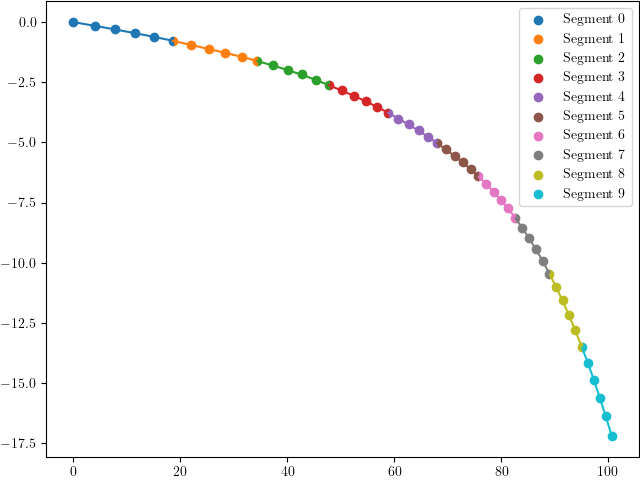

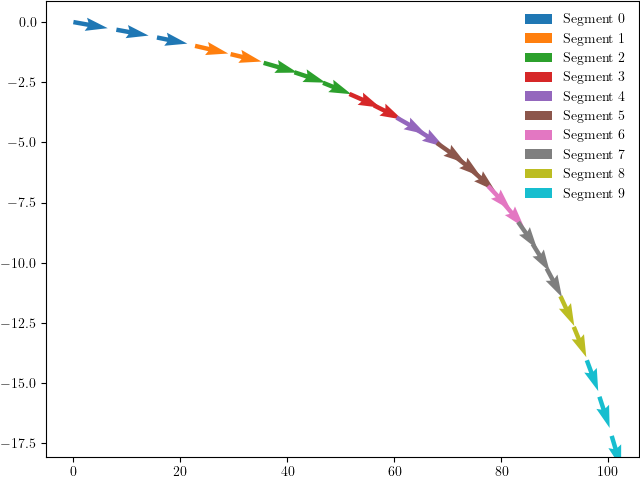

In [22]:
import deepracing_models.math_utils
from matplotlib.markers import MarkerStyle

print(barte_results.keys())
device = torch.device("cpu")
dtype = torch.float64
predicted_curve = torch.as_tensor(barte_results["curves"][idx_rand], device=device, dtype=dtype)
predicted_curve = (torch.as_tensor(Rmat[0:2,0:2], device=device, dtype=dtype)[None, None] @ predicted_curve[...,None]).squeeze(-1)
tfuture_torch = torch.as_tensor(tfuture - tfuture[0], device=device, dtype=dtype)
tswitch = torch.linspace(0.0, tfuture_torch[-1], steps=predicted_curve.shape[0] + 1, device=device, dtype=dtype)
tstart = tswitch[:-1]
dt = tswitch[1:] - tstart
bezier_order = predicted_curve.shape[-2] - 1
predicted_vel_curve = bezier_order*(predicted_curve[:,1:] - predicted_curve[:,:-1])/dt[...,None,None]


tsamp_torch = torch.linspace(0.0, tfuture_torch[-1].item(), steps=25, dtype=dtype, device=device)

tsamp_torch_dense = torch.linspace(0.0, tfuture_torch[-1].item(), steps=600, dtype=dtype, device=device)
predicted_positions_dense, idx_buckets_dense = deepracing_models.math_utils.compositeBezierEval(tstart, dt, predicted_curve, tsamp_torch_dense)

predicted_vels, _ = deepracing_models.math_utils.compositeBezierEval(tstart, dt, predicted_vel_curve, tsamp_torch)

fig_positions, _ax_positions_ = plt.subplots()
ax_positions : matplotlib.axes.Axes = _ax_positions_
segments_colors = []
bool_idx = idx_buckets_dense==0
current_control_points = predicted_curve[0].cpu()
current_positions = predicted_positions_dense[bool_idx]
current_color = ax_positions.plot(current_positions[:,0], current_positions[:,1])[0].get_color()
ax_positions.scatter(current_control_points[:-1,0], current_control_points[:-1,1], c=current_color, label="Segment 0")
segments_colors.append(current_color)
for curve_idx in range(1, predicted_curve.shape[0]):
    bool_idx = idx_buckets_dense==curve_idx
    current_positions = predicted_positions_dense[bool_idx]
    current_color = ax_positions.plot(current_positions[:,0], current_positions[:,1])[0].get_color()
    segments_colors.append(current_color)
    label="Segment %d" % (curve_idx,)

    current_control_points = predicted_curve[curve_idx].cpu()
    ax_positions.scatter(current_control_points[1:-1,0], current_control_points[1:-1,1], c=current_color, label=label)
    ax_positions.scatter(current_control_points[0,0], current_control_points[0,1], c=current_color, edgecolor=None, marker=MarkerStyle("o", fillstyle="right"))
    ax_positions.scatter(current_control_points[0,0], current_control_points[0,1], c=segments_colors[-2], edgecolor=None, marker=MarkerStyle("o", fillstyle="left"))
ax_positions.scatter(predicted_curve[-1,-1,0], predicted_curve[-1,-1,1], c=segments_colors[-1])
ax_positions.legend()
# ax_positions.axis("equal")
# ax_positions.axis("equal")
predicted_positions, idx_buckets = deepracing_models.math_utils.compositeBezierEval(tstart, dt, predicted_curve, tsamp_torch)
fig_arrows, _ax_arrows_ = plt.subplots()
ax_arrows : matplotlib.axes.Axes = _ax_arrows_
skip=4
for curve_idx in range(predicted_curve.shape[0]):
    bool_idx = idx_buckets==curve_idx
    current_positions = predicted_positions[bool_idx]
    current_vels = predicted_vels[bool_idx]
    current_color = segments_colors[curve_idx]
    label="Segment %d" % (curve_idx,)
    ax_arrows.quiver(current_positions[:,0], current_positions[:,1], current_vels[:,0], current_vels[:,-1], angles="xy", color=current_color, label=label)
ax_arrows.legend(frameon=False)
# ax_arrows.axis("equal")
fig_positions.tight_layout(pad=0.1)
fig_positions.savefig(os.path.join(plots_dir, "positions.svg"), pad_inches=0.02)
fig_positions.savefig(os.path.join(plots_dir, "positions.png"), backend="agg", pad_inches=0.02)
fig_arrows.tight_layout(pad=0.1)
fig_arrows.savefig(os.path.join(plots_dir, "arrows.svg"), pad_inches=0.02)
fig_arrows.savefig(os.path.join(plots_dir, "arrows.png"), backend="agg", pad_inches=0.02)